In [1]:
!pip install watermark
%reload_ext watermark
%watermark -v -m -p numpy,matplotlib,sklearn,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.26.4
matplotlib  : 3.7.5
sklearn     : 1.2.2
pandas      : 2.2.3
torch       : 2.5.1+cu121
transformers: 4.47.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.6.56+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit



In [ ]:
import os

# Define the directory path
models_dir = "models"

# Create the directory if it doesn't exist
os.makedirs(models_dir, exist_ok=True)

print(f"Models directory created at: {models_dir}")

Models directory created at: /kaggle/working/models


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import random
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Load Data

In [ ]:
# load data data/imdb.csv
train_df = pd.read_csv('data/train_split.tsv', sep='\t')
test_df = pd.read_csv('data/test.tsv', sep='\t', header=None, names=['text', 'label'])
val_df = pd.read_csv('data/val_split.tsv', sep='\t')

# test_df.head()
train_df.head()

,text,label
0,graphic sex may be what 's attracting audience...,1
1,perhaps the grossest movie ever made,0
2,"the film is moody , oozing , chilling and hear...",1
3,watching the chemistry between freeman and jud...,1
4,the wonderfully lush morvern callar is pure pu...,1


In [ ]:
imdb_train_df = pd.read_csv('data/train_imdb_split.csv')
imdb_val_df = pd.read_csv('data/val_imdb_split.csv')
imdb_test_df = pd.read_csv('data/test_imdb_split.csv')

imdb_train_df.head()

,text,label
0,With no fault to the actors (they all put on g...,0
1,The first thing I thought when I saw this film...,1
2,Post-feminist depiction of cruelty and sadism....,1
3,OMG this is one of the worst films iv ever see...,0
4,"The Box is a film with great potential, but th...",0


### Model

In [7]:
import torch
import torch.nn as nn

class MLP_Model(nn.Module):
    def __init__(self, input_size=10000, hidden_sizes=[512, 256, 128, 64], output_size=2, dropout_rate=0.3):
        super(MLP_Model, self).__init__()

        self.layers = nn.ModuleDict({
            "Layer 1": nn.Sequential(
                nn.Linear(input_size, hidden_sizes[0]),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ),
            "Layer 2": nn.Sequential(
                nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ),
            "Layer 3": nn.Sequential(
                nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ),
            "Layer 4": nn.Sequential(
                nn.Linear(hidden_sizes[2], hidden_sizes[3]),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ),
            "Layer 5": nn.Linear(hidden_sizes[3], output_size)
        })

    def forward(self, x):
        for name, layer in self.layers.items():
            x = layer(x)
        return x

model = MLP_Model()
print(model)

MLP_Model(
  (layers): ModuleDict(
    (Layer 1): Sequential(
      (0): Linear(in_features=10000, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
    )
    (Layer 2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
    )
    (Layer 3): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
    )
    (Layer 4): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
    )
    (Layer 5): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [8]:
sum_params = 0

for name, param in model.named_parameters():
    print(f'Layer: {name} | Size: {param.size()} | Params: {param.numel()} | Trainable: {param.requires_grad}')
    if param.requires_grad:
        sum_params += param.numel()

print(f'Total Trainable Parameters: {sum_params}')

Layer: layers.Layer 1.0.weight | Size: torch.Size([512, 10000]) | Params: 5120000 | Trainable: True
Layer: layers.Layer 1.0.bias | Size: torch.Size([512]) | Params: 512 | Trainable: True
Layer: layers.Layer 2.0.weight | Size: torch.Size([256, 512]) | Params: 131072 | Trainable: True
Layer: layers.Layer 2.0.bias | Size: torch.Size([256]) | Params: 256 | Trainable: True
Layer: layers.Layer 3.0.weight | Size: torch.Size([128, 256]) | Params: 32768 | Trainable: True
Layer: layers.Layer 3.0.bias | Size: torch.Size([128]) | Params: 128 | Trainable: True
Layer: layers.Layer 4.0.weight | Size: torch.Size([64, 128]) | Params: 8192 | Trainable: True
Layer: layers.Layer 4.0.bias | Size: torch.Size([64]) | Params: 64 | Trainable: True
Layer: layers.Layer 5.weight | Size: torch.Size([2, 64]) | Params: 128 | Trainable: True
Layer: layers.Layer 5.bias | Size: torch.Size([2]) | Params: 2 | Trainable: True
Total Trainable Parameters: 5293122


### Bag-of-words

The bag-of-words model (BoW) is a model of text which uses an unordered collection (a "bag") of words. It disregards word order (and thus most of syntax or grammar) but captures multiplicity.

Each key is the word, and each value is the number of occurrences of that word in the given text document.

```javascript
(1) John likes to watch movies. Mary likes movies too.

(2) Mary also likes to watch football games.
```

Based on these two text documents, a list is constructed as follows for each document:

```javascript
"John","likes","to","watch","movies","Mary","likes","movies","too"

"Mary","also","likes","to","watch","football","games"
```

Representing each bag-of-words as a JSON object, and attributing to the respective JavaScript variable:

```javascript
BoW1 = {"John":1,"likes":2,"to":1,"watch":1,"movies":2,"Mary":1,"too":1};

BoW2 = {"Mary":1,"also":1,"likes":1,"to":1,"watch":1,"football":1,"games":1};
```

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_dataset = TextDataset(train_df["text"].tolist(), train_df["label"].tolist())
val_dataset = TextDataset(val_df["text"].tolist(), val_df["label"].tolist())
test_dataset = TextDataset(test_df["text"].tolist(), test_df["label"].tolist())

In [ ]:
BATCH_SIZE = 32

# fit CountVectorizer on training data
vectorizer = CountVectorizer(max_features=10000)
vectorizer.fit(train_df["text"])

def bow_collate_fn(batch):
    texts, labels = zip(*batch)  # Unpack batch into texts and labels
    X_batch = vectorizer.transform(texts).toarray()  # Vectorize texts using BoW
    X_batch_tensor = torch.tensor(X_batch, dtype=torch.float32)  # Convert to tensor
    y_batch_tensor = torch.tensor(labels, dtype=torch.long)  # Convert labels to tensor
    return X_batch_tensor, y_batch_tensor

train_loader_bow = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=bow_collate_fn)
val_loader_bow = DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle = False, collate_fn=bow_collate_fn)
test_loader_bow = DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle= False, collate_fn=bow_collate_fn)

print(f"Number of training batches: {len(train_loader_bow)}")
print(f"Number of validation batches: {len(val_loader_bow)}")
print(f"Number of test batches: {len(test_loader_bow)}")


Number of training batches: 173
Number of validation batches: 44
Number of test batches: 57


In [11]:
import numpy as np

# Map word indices to words
word2idx = vectorizer.vocabulary_
idx2word = {v: k for k, v in word2idx.items()}

sample_number = 5 

# Take a specific sample from the validation DataFrame
val_text_sample = val_df.text.iloc[sample_number]  # Select the sample from validation set
val_label_sample = val_df.label.iloc[sample_number]  # Get the corresponding label
print("Original Sentence:", val_text_sample.split())
print("Original sentence label:", val_label_sample)

# Get the first batch from val_loader_bow
X_batch, y_batch = next(iter(val_loader_bow))  # Get the first batch from DataLoader

# Extract the specific sample from the first batch
X_bow_sample = X_batch[sample_number]
y_bow_sample = y_batch[sample_number]

# Print BoW representation details
print("BoW representation shape:", X_bow_sample.shape)
print("BoW representation:", X_bow_sample)

# Find non-zero indices in the BoW representation
nonzero_indices = torch.nonzero(X_bow_sample).flatten().numpy()  # Non-zero indices correspond to words present in the sentence
print("Non-zero indices:", nonzero_indices)

# Map non-zero indices back to words using idx2word
words_in_sentence = [idx2word[idx] for idx in nonzero_indices]
print("Words in BoW representation:", words_in_sentence)

# Compare with original sentence (sorted)
original_words_sorted = sorted(val_text_sample.split())
print("Original words in sentence (sorted):", original_words_sorted)

# Print lengths for comparison
print("Length of original sentence:", len(original_words_sorted))
print("Length of BoW-represented words:", len(words_in_sentence))


Original Sentence: ['tara', 'reid', 'plays', 'a', 'college', 'journalist', ',', 'but', 'she', 'looks', 'like', 'the', 'six', 'time', 'winner', 'of', 'the', 'miss', 'hawaiian', 'tropic', 'pageant', ',', 'so', 'i', 'do', "n't", 'know', 'what', 'she', "'s", 'doing', 'in', 'here']
Original sentence label: 0
BoW representation shape: torch.Size([10000])
BoW representation: tensor([0., 0., 0.,  ..., 0., 0., 0.])
Non-zero indices: [ 766 1046 1967 1990 3861 3938 4321 4794 4936 5190 5294 5785 6292 6901
 8501 8670 8796 9301 9371 9830 9875]
Words in BoW representation: ['but', 'college', 'do', 'doing', 'hawaiian', 'here', 'in', 'journalist', 'know', 'like', 'looks', 'miss', 'of', 'plays', 'she', 'six', 'so', 'the', 'time', 'what', 'winner']
Original words in sentence (sorted): ["'s", ',', ',', 'a', 'but', 'college', 'do', 'doing', 'hawaiian', 'here', 'i', 'in', 'journalist', 'know', 'like', 'looks', 'miss', "n't", 'of', 'pageant', 'plays', 'reid', 'she', 'she', 'six', 'so', 'tara', 'the', 'the', 

###  Embedding Model bert-base-uncased

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [13]:
from transformers import AutoTokenizer, AutoModel

model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name)
print(tokenizer)

bert = AutoModel.from_pretrained(model_name)

embedding_size = bert.config.hidden_size
print('Embedding size:',embedding_size)

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)
Embedding size: 768


In [14]:
bert.eval()
bert.to(device)

text = 'hello world'
inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
print(inputs['input_ids'])
print(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))

with torch.no_grad():
    outputs = bert(**inputs.to(device))

embeddings = outputs.last_hidden_state
print('First id:',inputs['input_ids'][0][1])
print('First token:',tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])[1])
print('Embedding shape:',embeddings.shape)


sentence_embeddings = torch.mean(embeddings, dim=1)
print('Sentence embedding shape:',sentence_embeddings.shape)

# CLS : first token, SEP : last token

tensor([[ 101, 7592, 2088,  102]])
['[CLS]', 'hello', 'world', '[SEP]']
First id: tensor(7592, device='cuda:0')
First token: hello
Embedding shape: torch.Size([1, 4, 768])
Sentence embedding shape: torch.Size([1, 768])


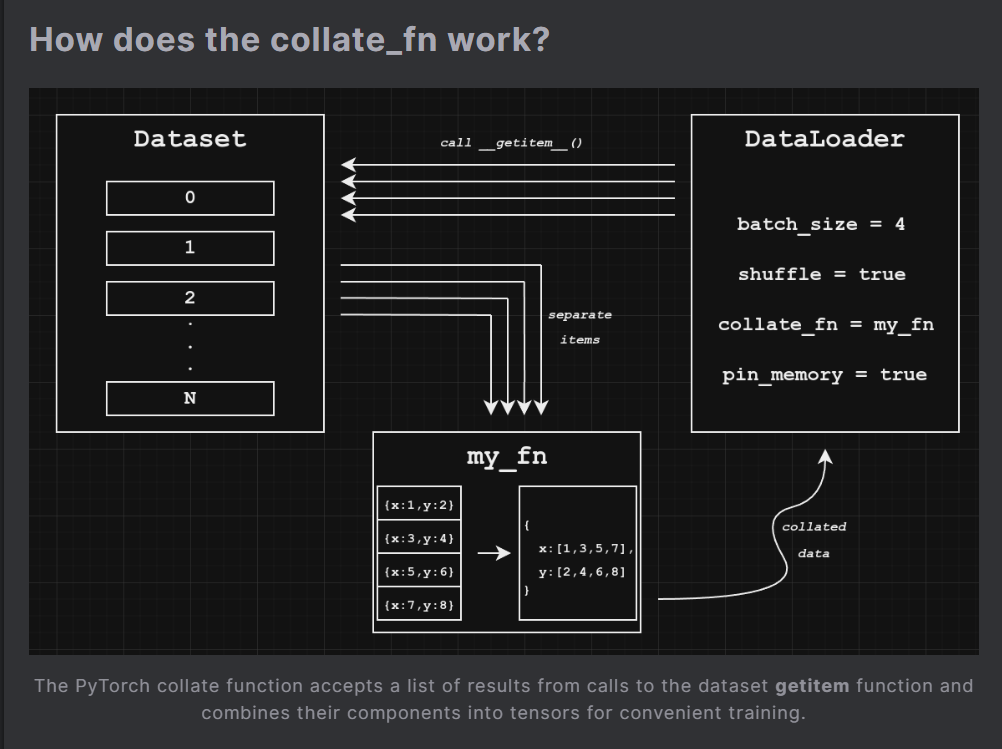

In [15]:
def get_bert_embeddings(inputs, bert, pooling_strategy='mean'):
    with torch.no_grad():
        outputs = bert(**inputs)
        
    embeddings = outputs.last_hidden_state
    
    if pooling_strategy == 'mean':
        sentence_embeddings = torch.mean(embeddings, dim=1)  # Mean pooling
    elif pooling_strategy == 'max':
        sentence_embeddings = torch.max(embeddings, dim=1).values  # Max pooling
    elif pooling_strategy == 'cls':
        sentence_embeddings = embeddings[:, 0, :]  # CLS token
    elif pooling_strategy == 'sep':
        sentence_embeddings = embeddings[:, -1, :]  # SEP token
    else:
        raise ValueError("Pooling strategy not valid")

    return sentence_embeddings

def bert_collate_fn(batch):
    texts = [item[0] for item in batch]
    labels = None
    if isinstance(batch[0], tuple) and len(batch[0]) > 1:
        labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)
    sentence_embeddings = get_bert_embeddings(inputs, bert, pooling_strategy=pooling_strategy)

    return sentence_embeddings.cpu() , labels

BATCH_SIZE = 32
pooling_strategy = 'mean'  

train_loader_bert = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=bert_collate_fn)
val_loader_bert = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=bert_collate_fn)
test_loader_bert = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=bert_collate_fn)

print(f"Number of training batches: {len(train_loader_bert)}")
print(f"Number of validation batches: {len(val_loader_bert)}")
print(f"Number of test batches: {len(test_loader_bert)}")

Number of training batches: 173
Number of validation batches: 44
Number of test batches: 57


In [16]:
# first sample from first batch of validation loader
X_bert_sample, y_bert_sample = next(iter(val_loader_bert))
print("BERT representation shape:", X_bert_sample.shape)
# print("BERT representation:", X_bert_sample[0])
print("BERT representation label:", y_bert_sample[0])

BERT representation shape: torch.Size([32, 768])
BERT representation label: tensor(0)


In [17]:
!nvidia-smi

Fri Mar 14 17:25:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P0             36W /  250W |     851MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Training on Dataset I

In [18]:
import torch
import torch.nn as nn

def train(model, model_path, optimizer, criterion, train_loader, val_loader, num_epochs, device):
    model.to(device)
    best_loss = float('inf')
    train_loss_history = []
    val_loss_history = []
    best_model_state = None

    best_acc =0

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader) 

        model.eval()
        val_loss = 0
        val_acc = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                y_pred_val = model(X_batch)
                loss = criterion(y_pred_val, y_batch)
                val_loss += loss.item()

                y_pred_val_class = torch.argmax(y_pred_val, dim=1)
                correct += torch.sum(y_pred_val_class == y_batch).item()
                total += y_batch.size(0)

        val_loss /= len(val_loader)  
        val_acc = correct / total

        print(f'Epoch: {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)

        # Save checkpoint after every epoch
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_acc': val_acc,
        }
        if epoch%2 ==0 :
            torch.save(checkpoint, f'{model_path}_epoch_{epoch}.pt')

        # if val_loss < best_loss:
        #     best_loss = val_loss
        #     best_model_state = model.state_dict()

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_state = model.state_dict()

    print('Best val acc:', best_acc)
    torch.save(best_model_state, model_path)

    return train_loss_history, val_loss_history


#### Training bow model

Epoch: 1 | Train Loss: 0.6917 | Val Loss: 0.6868 | Val Acc: 0.5181
Epoch: 2 | Train Loss: 0.5854 | Val Loss: 0.4810 | Val Acc: 0.7760
Epoch: 3 | Train Loss: 0.2842 | Val Loss: 0.4710 | Val Acc: 0.8027
Epoch: 4 | Train Loss: 0.1238 | Val Loss: 0.7117 | Val Acc: 0.7616
Epoch: 5 | Train Loss: 0.0573 | Val Loss: 0.6531 | Val Acc: 0.8078
Epoch: 6 | Train Loss: 0.0267 | Val Loss: 0.7416 | Val Acc: 0.8100
Epoch: 7 | Train Loss: 0.0166 | Val Loss: 0.8702 | Val Acc: 0.7926
Epoch: 8 | Train Loss: 0.0102 | Val Loss: 0.9232 | Val Acc: 0.7941
Epoch: 9 | Train Loss: 0.0063 | Val Loss: 1.0499 | Val Acc: 0.7934
Epoch: 10 | Train Loss: 0.0054 | Val Loss: 1.0957 | Val Acc: 0.7948
Best val acc: 0.809971098265896


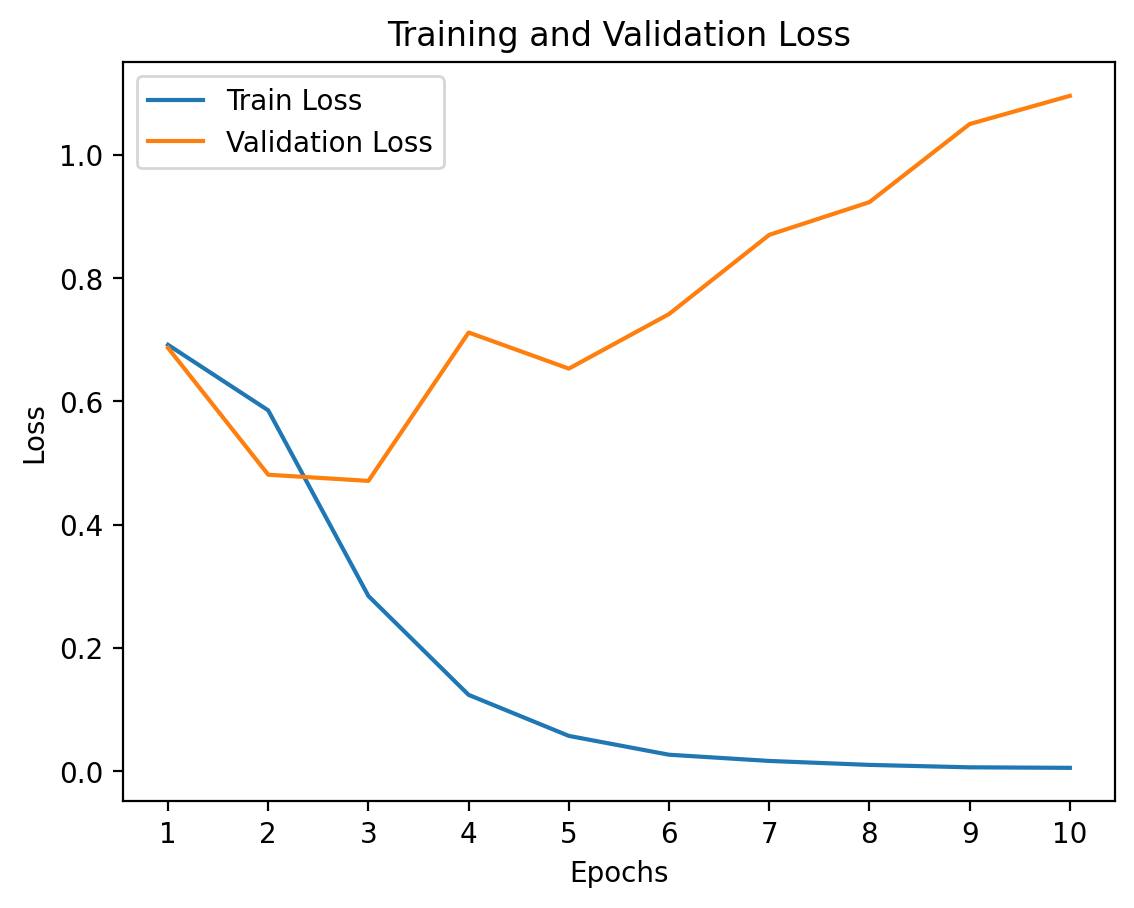

In [ ]:
import torch.optim as optim

bow_model = MLP_Model(input_size=10000)
bow_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bow_model.parameters(), lr=1e-4)

num_epochs = 10

epochs = list(range(1, num_epochs + 1))
train_loss_history, val_loss_history = train(
    bow_model,
    'models/bow_1.pt',
    optimizer,
    criterion,
    train_loader_bow,
    val_loader_bow,
    num_epochs,
    device
)

# Plot the training and validation loss history
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

#### Training bert model

Epoch: 1 | Train Loss: 0.6170 | Val Loss: 0.4148 | Val Acc: 0.8129
Epoch: 2 | Train Loss: 0.3796 | Val Loss: 0.3161 | Val Acc: 0.8540
Epoch: 3 | Train Loss: 0.3437 | Val Loss: 0.3052 | Val Acc: 0.8605
Epoch: 4 | Train Loss: 0.3229 | Val Loss: 0.3018 | Val Acc: 0.8736
Epoch: 5 | Train Loss: 0.3156 | Val Loss: 0.3093 | Val Acc: 0.8548
Epoch: 6 | Train Loss: 0.3074 | Val Loss: 0.2941 | Val Acc: 0.8678
Epoch: 7 | Train Loss: 0.2938 | Val Loss: 0.2953 | Val Acc: 0.8707
Epoch: 8 | Train Loss: 0.2808 | Val Loss: 0.3101 | Val Acc: 0.8605
Epoch: 9 | Train Loss: 0.2698 | Val Loss: 0.2991 | Val Acc: 0.8656
Epoch: 10 | Train Loss: 0.2473 | Val Loss: 0.3097 | Val Acc: 0.8714
Best val acc: 0.8735549132947977


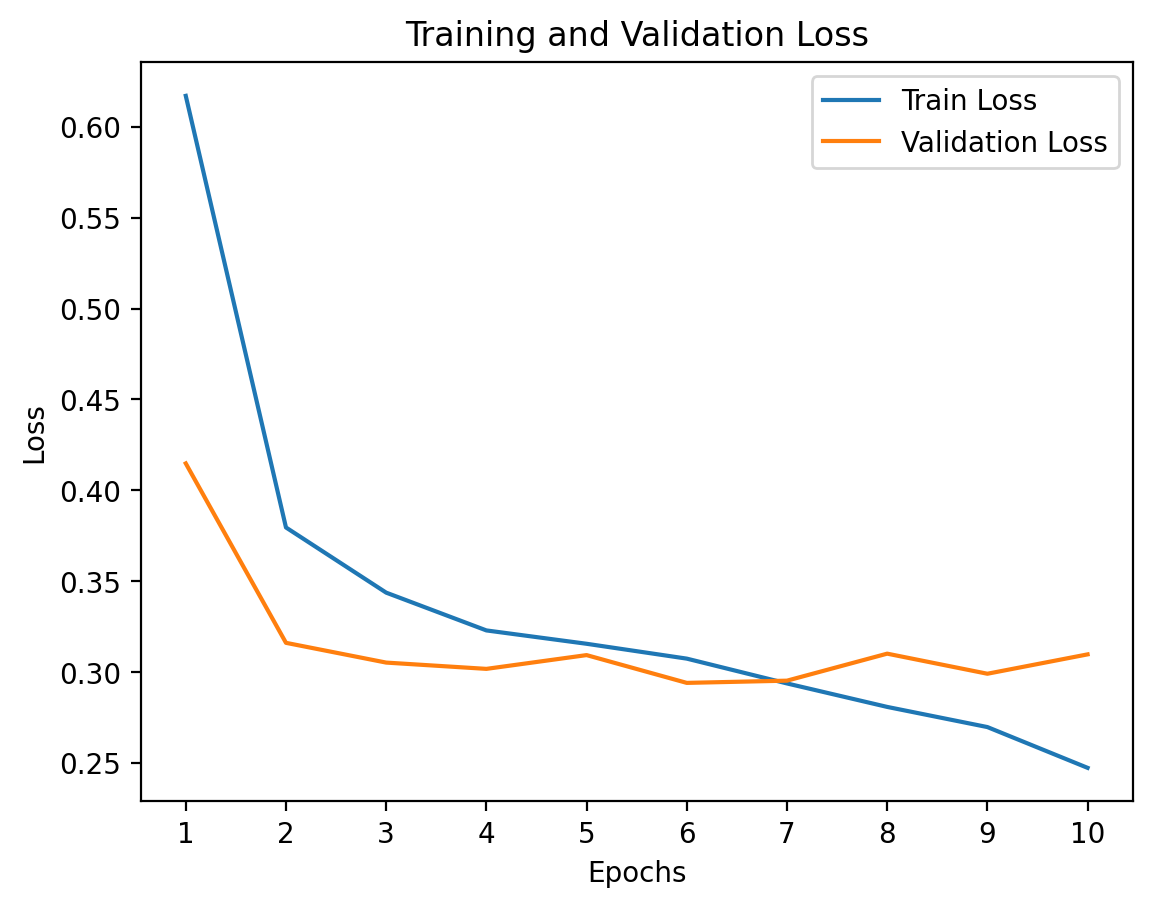

In [ ]:
import torch.optim as optim

bert_model = MLP_Model(input_size=embedding_size)
bert_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bert_model.parameters(), lr=1e-4)

num_epochs = 10

epochs = list(range(1, num_epochs + 1))
train_loss_history3, val_loss_history3 = train(
    bert_model,
    'models/bert_1.pt',
    optimizer,
    criterion,
    train_loader_bert,
    val_loader_bert,
    num_epochs,
    device
)

plt.plot(epochs, train_loss_history3, label='Train Loss')
plt.plot(epochs, val_loss_history3, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### Testing on Dataset I

Test Loss: 1.1145
Accuracy: 0.7930


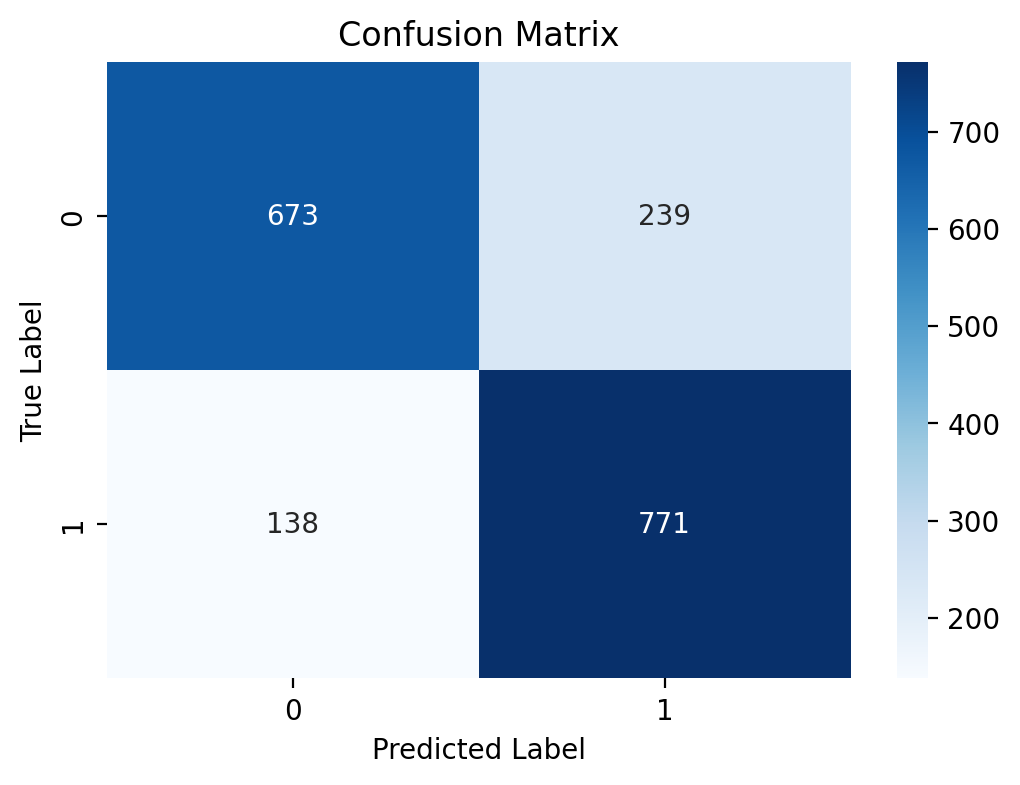

In [21]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def test(model, criterion, test_loader, device):
    model.eval()
    test_loss = 0
    all_y_true = []
    all_y_pred = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Forward pass
            y_pred_logits = model(X_batch)  # shape: (batch_size, num_classes)
            loss = criterion(y_pred_logits, y_batch)
            test_loss += loss.item()

            # Get predicted labels
            y_pred_labels = torch.argmax(y_pred_logits, dim=1)  # Predicted class indices

            # Collect true and predicted labels for metrics
            all_y_true.extend(y_batch.cpu().numpy())
            all_y_pred.extend(y_pred_labels.cpu().numpy())

    # Average test loss over all batches
    test_loss /= len(test_loader)

    # Compute metrics
    accuracy = accuracy_score(all_y_true, all_y_pred)
    conf_matrix = confusion_matrix(all_y_true, all_y_pred)

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Accuracy: {accuracy:.4f}')

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, conf_matrix

accuracy_bow_1, conf_matrix_bow_1 = test(bow_model, criterion, test_loader_bow, device)

Test Loss: 0.3167
Accuracy: 0.8655


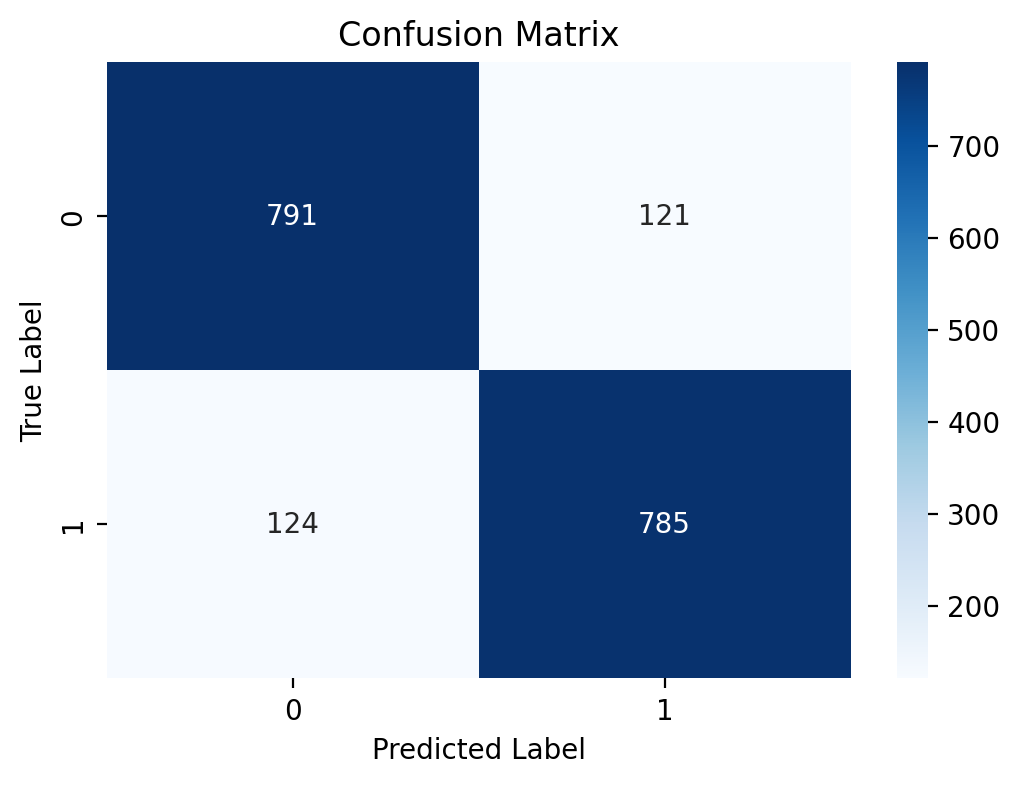

In [22]:
accuracy_bow_3, conf_matrix_bow_3 = test(bert_model, criterion, test_loader_bert, device)

#### checkpoint compression

In [ ]:
import shutil

# Define the models directory
models_dir = "models"

# Create a zip file
shutil.make_archive("models_backup", 'zip', models_dir)

print("Models folder zipped successfully!")

Models folder zipped successfully!


In [25]:
torch.cuda.empty_cache()

import gc
gc.collect()

14325

### Training on Dataset II

#### Training bow model 

In [ ]:
train_imdb_dataset = TextDataset(imdb_train_df["text"].tolist(), imdb_train_df["label"].tolist())
val_imdb_dataset = TextDataset(imdb_val_df["text"].tolist(), imdb_val_df["label"].tolist())
test_imdb_dataset = TextDataset(imdb_test_df["text"].tolist(), imdb_test_df["label"].tolist())

train_loader_bow_imdb = DataLoader(train_imdb_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=bow_collate_fn)
val_loader_bow_imdb = DataLoader(val_imdb_dataset, batch_size=BATCH_SIZE,shuffle = False, collate_fn=bow_collate_fn)
test_loader_bow_imdb = DataLoader(test_imdb_dataset, batch_size=BATCH_SIZE,shuffle= False, collate_fn=bow_collate_fn)

print(f"Number of training batches: {len(train_loader_bow_imdb)}")
print(f"Number of validation batches: {len(val_loader_bow_imdb)}")
print(f"Number of test batches: {len(test_loader_bow_imdb)}")

Number of training batches: 1000
Number of validation batches: 250
Number of test batches: 57


<ipython-input-27-eda9b00f0f99>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bow_model_2.load_state_dict(torch.load('models/bow_1.pt'))


model loaded
Epoch: 1 | Train Loss: 0.8659 | Val Loss: 0.3077 | Val Acc: 0.8720
Epoch: 2 | Train Loss: 0.2586 | Val Loss: 0.2743 | Val Acc: 0.8892
Epoch: 3 | Train Loss: 0.1761 | Val Loss: 0.3093 | Val Acc: 0.8830
Epoch: 4 | Train Loss: 0.1018 | Val Loss: 0.3514 | Val Acc: 0.8838
Epoch: 5 | Train Loss: 0.0584 | Val Loss: 0.3898 | Val Acc: 0.8848
Epoch: 6 | Train Loss: 0.0376 | Val Loss: 0.4773 | Val Acc: 0.8850
Epoch: 7 | Train Loss: 0.0250 | Val Loss: 0.5380 | Val Acc: 0.8845
Epoch: 8 | Train Loss: 0.0208 | Val Loss: 0.5733 | Val Acc: 0.8838
Epoch: 9 | Train Loss: 0.0197 | Val Loss: 0.5530 | Val Acc: 0.8866
Epoch: 10 | Train Loss: 0.0144 | Val Loss: 0.6441 | Val Acc: 0.8822
Best val acc: 0.88925


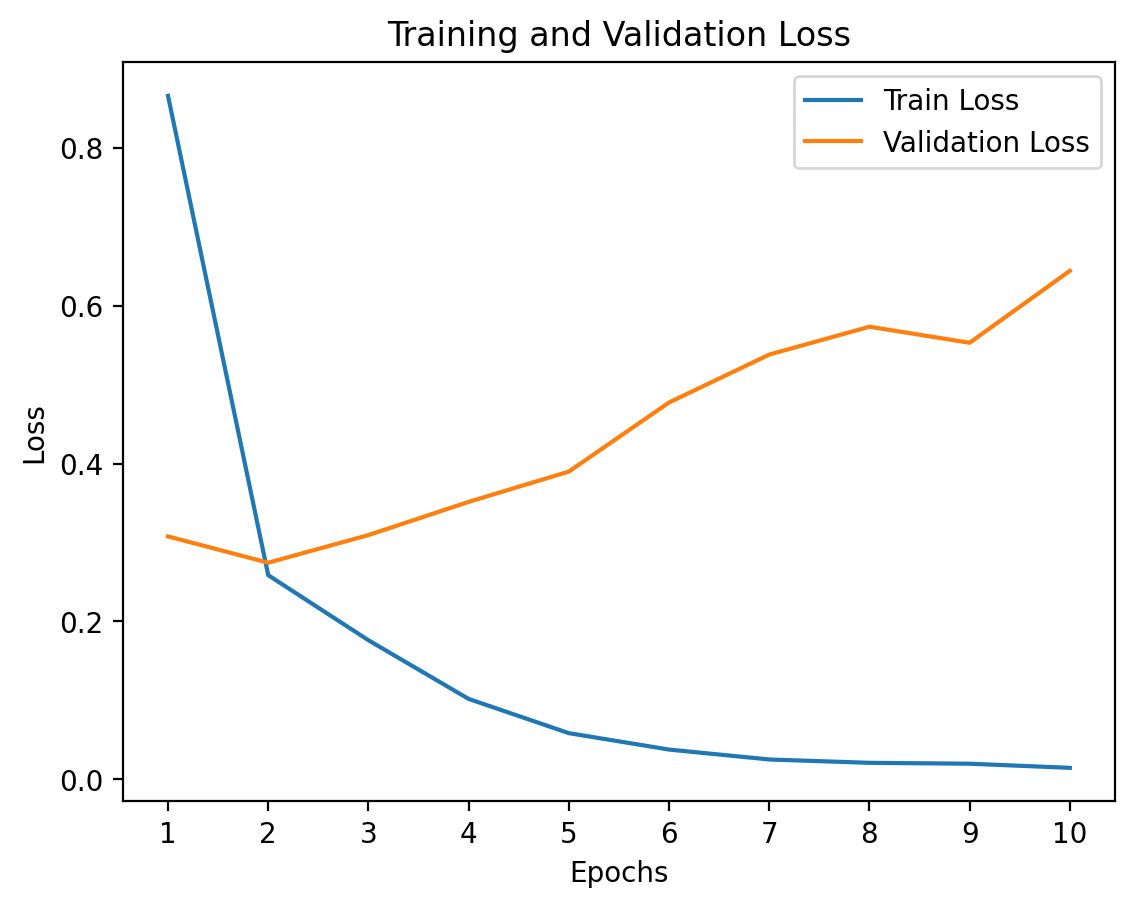

In [ ]:
import torch.optim as optim 

# Load the check pointed model
bow_model_2 = MLP_Model(input_size=10000)
bow_model_2.load_state_dict(torch.load('models/bow_1.pt'))
bow_model_2.to(device)

print('model loaded')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bow_model_2.parameters(), lr=1e-4)

num_epochs = 10

epochs = list(range(1, num_epochs + 1))
train_loss_history, val_loss_history = train(
    bow_model_2,
    'models/bow_2.pt',
    optimizer,
    criterion,
    train_loader_bow_imdb,
    val_loader_bow_imdb,
    num_epochs,
    device
)

plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

#### Training bert model

In [28]:
train_loader_bert_imdb = DataLoader(train_imdb_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=bert_collate_fn)
val_loader_bert_imdb = DataLoader(val_imdb_dataset, batch_size=BATCH_SIZE,shuffle = False, collate_fn=bert_collate_fn)
test_loader_bert_imdb = DataLoader(test_imdb_dataset, batch_size=BATCH_SIZE,shuffle= False, collate_fn=bert_collate_fn)

print(f"Number of training batches: {len(train_loader_bert_imdb)}")
print(f"Number of validation batches: {len(val_loader_bert_imdb)}")
print(f"Number of test batches: {len(test_loader_bert)}")

Number of training batches: 1000
Number of validation batches: 250
Number of test batches: 57


<ipython-input-29-884dbd6df4d1>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bert_model_2.load_state_dict(torch.load('models/bert_1.pt'))


model loaded
Epoch: 1 | Train Loss: 0.3273 | Val Loss: 0.2958 | Val Acc: 0.8722
Epoch: 2 | Train Loss: 0.2994 | Val Loss: 0.3128 | Val Acc: 0.8645
Epoch: 3 | Train Loss: 0.2883 | Val Loss: 0.2864 | Val Acc: 0.8771
Epoch: 4 | Train Loss: 0.2825 | Val Loss: 0.2735 | Val Acc: 0.8842
Epoch: 5 | Train Loss: 0.2775 | Val Loss: 0.2690 | Val Acc: 0.8869
Epoch: 6 | Train Loss: 0.2699 | Val Loss: 0.2685 | Val Acc: 0.8895
Epoch: 7 | Train Loss: 0.2663 | Val Loss: 0.2716 | Val Acc: 0.8848
Epoch: 8 | Train Loss: 0.2616 | Val Loss: 0.2610 | Val Acc: 0.8912
Epoch: 9 | Train Loss: 0.2575 | Val Loss: 0.2621 | Val Acc: 0.8920
Epoch: 10 | Train Loss: 0.2536 | Val Loss: 0.2626 | Val Acc: 0.8919
Best val acc: 0.892


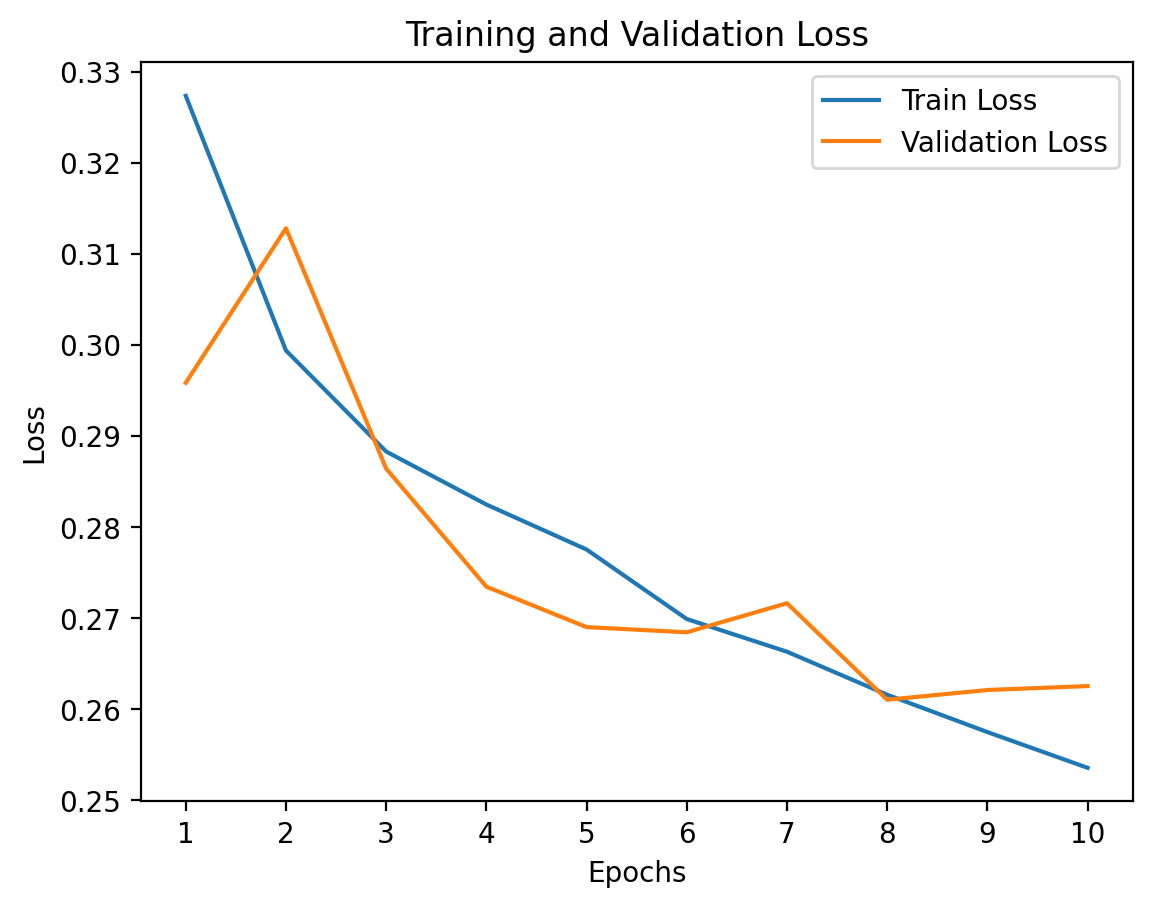

In [ ]:
import torch.optim as optim 

# Load the check pointed model
bert_model_2 = MLP_Model(input_size=embedding_size)
bert_model_2.load_state_dict(torch.load('models/bert_1.pt'))
bert_model_2.to(device)

print('model loaded')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bert_model_2.parameters(), lr=1e-4)

num_epochs = 10

epochs = list(range(1, num_epochs + 1))
train_loss_history, val_loss_history = train(
    bert_model_2,
    'models/bert_2.pt',
    optimizer,
    criterion,
    train_loader_bert_imdb,
    val_loader_bert_imdb,
    num_epochs,
    device
)

plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### Testing on Dataset II

Test Loss: 0.6468
Accuracy: 0.8812


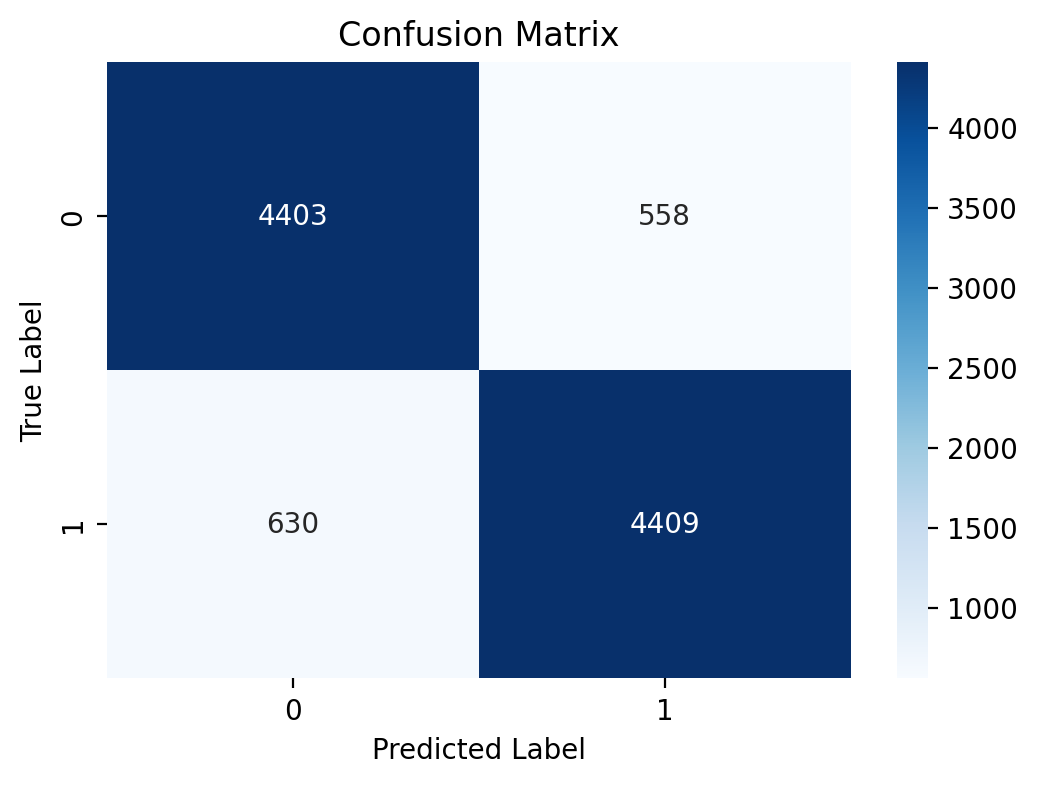

In [30]:
accuracy_bow_2, conf_matrix_bow_2 = test(bow_model_2, criterion, test_loader_bow_imdb, device)

Test Loss: 0.2663
Accuracy: 0.8890


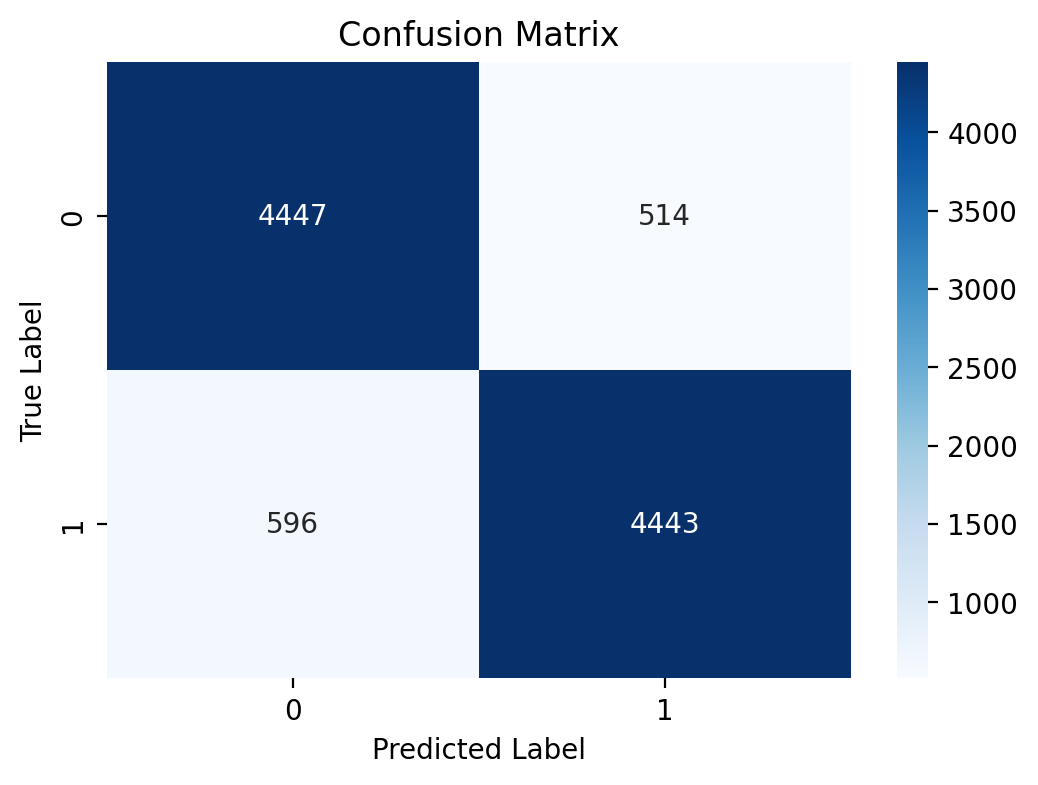

In [31]:
accuracy_bert_2, conf_matrix_bert_2 = test(bert_model_2, criterion, test_loader_bert_imdb, device)